# Import libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from skimage import measure

from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

2024-08-26 13:35:21.084871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 13:35:21.085058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 13:35:21.238733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing model and pre fucntions

In [2]:
width = 256
height = 256
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [3]:
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model('/kaggle/input/segmentation-model/segmentation_model/segmentation.h5')

# Qualitative evalaution via overlay and contour

In [4]:
# Function to preprocess and predict on a new image
def predict_and_overlay(image_path, model):
    # Read the new image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()  # Keep a copy for visualization later

    # Preprocess the image (resize, normalize)
    resized_image = cv2.resize(image, (256, 256))  # Adjust as per your model's input size
    preprocessed_image = resized_image.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Make prediction
    input_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    predicted_mask = model.predict(input_image)[0]  # Assuming model output is the predicted mask

    # Post-process the predicted mask (thresholding, resizing if necessary)
    thresholded_mask = (predicted_mask >= 0.5).astype(np.uint8)  # Example thresholding

    # Resize the mask to match original image dimensions
    resized_mask = cv2.resize(thresholded_mask, (original_image.shape[1], original_image.shape[0]))
    
    # Create overlay by highlighting tumor regions on the original image
    overlay = original_image.copy()
    overlay[resized_mask == 1] = (0, 0, 255)  # Highlight tumor regions in red
    
    # Find contours of the tumor region
    contours = measure.find_contours(resized_mask, level=0.5)

    # Fix contour coordinates to match the overlay
    for contour in contours:
        contour = np.flip(contour, axis=1).astype(np.int32)  # Flip the coordinates to match the image orientation
        cv2.polylines(overlay, [contour], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Add transparency (alpha blending)
    alpha = 0.5
    blended = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

    # Display the overlayed image using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title('Tumour Detected')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


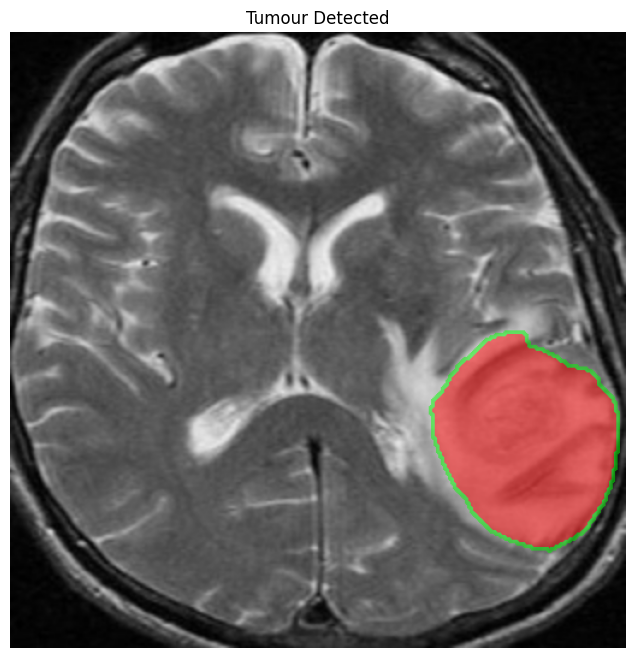

In [6]:
image_path = '/kaggle/input/segmentation-data/aryas/images/65.png'
predict_and_overlay(image_path, model)

# Qualitative evaluation via heatmap

In [7]:
def predict_and_overlay_with_heatmap(image_path, model):
    # Read the new image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()

    # Preprocess the image
    resized_image = cv2.resize(image, (256, 256))
    preprocessed_image = resized_image.astype(np.float32) / 255.0

    # Make prediction
    input_image = np.expand_dims(preprocessed_image, axis=0)
    predicted_mask = model.predict(input_image)[0]

    # Resize predicted mask to match the original image dimensions
    heatmap_mask = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))

    # Normalize the heatmap to the range [0, 1] for proper coloring
    heatmap_mask = np.clip(heatmap_mask, 0, 1)

    # Generate the heatmap using seaborn
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_mask, cmap='jet', alpha=0.6, zorder=2)  # 'jet' colormap for heatmap

    # Overlay the heatmap on the original image
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), alpha=0.4, zorder=1)
    plt.title('Tumor Segmentation Heatmap')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


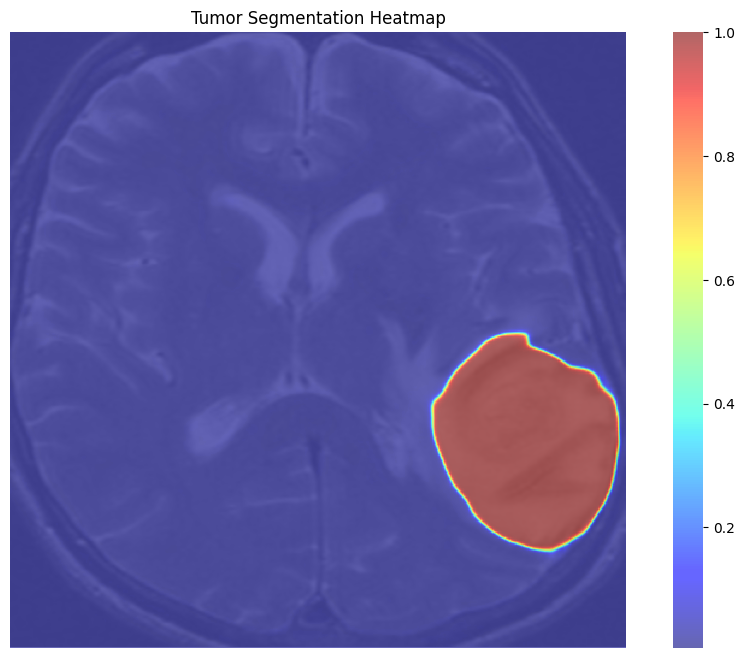

In [8]:
# Example usage
image_path = '/kaggle/input/segmentation-data/aryas/images/65.png'
predict_and_overlay_with_heatmap(image_path, model)

# Final presentable results

In [9]:
def predict_and_display_combined(image_path, model):
    # Read the new image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()

    # Preprocess the image (resize, normalize)
    resized_image = cv2.resize(image, (256, 256))
    preprocessed_image = resized_image.astype(np.float32) / 255.0

    # Make prediction
    input_image = np.expand_dims(preprocessed_image, axis=0)
    predicted_mask = model.predict(input_image)[0]

    # Post-process the predicted mask (thresholding, resizing)
    thresholded_mask = (predicted_mask >= 0.5).astype(np.uint8)
    resized_mask = cv2.resize(thresholded_mask, (original_image.shape[1], original_image.shape[0]))

    # Create overlay by highlighting tumor regions on the original image
    overlay = original_image.copy()
    overlay[resized_mask == 1] = (0, 0, 255)  # Highlight tumor regions in red
    
    # Find contours of the tumor region
    contours = measure.find_contours(resized_mask, level=0.5)

    # Fix contour coordinates to match the overlay
    for contour in contours:
        contour = np.flip(contour, axis=1).astype(np.int32)  # Flip the coordinates to match the image orientation
        cv2.polylines(overlay, [contour], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Add transparency (alpha blending) for overlay
    alpha = 0.5
    blended_overlay = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

    # Normalize the heatmap to the range [0, 1] for proper coloring
    heatmap_mask = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))
    heatmap_mask = np.clip(heatmap_mask, 0, 1)

    # Create the figure to display both visualizations side by side
    plt.figure(figsize=(20, 8))

    # Display the overlayed image with contours
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(blended_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Detected with Overlay and Contour')
    plt.axis('off')

    # Display the heatmap overlayed on the original image
    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_mask, cmap='jet', alpha=0.6, zorder=2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), alpha=0.4, zorder=1)
    plt.title('Tumor Segmentation Heatmap')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


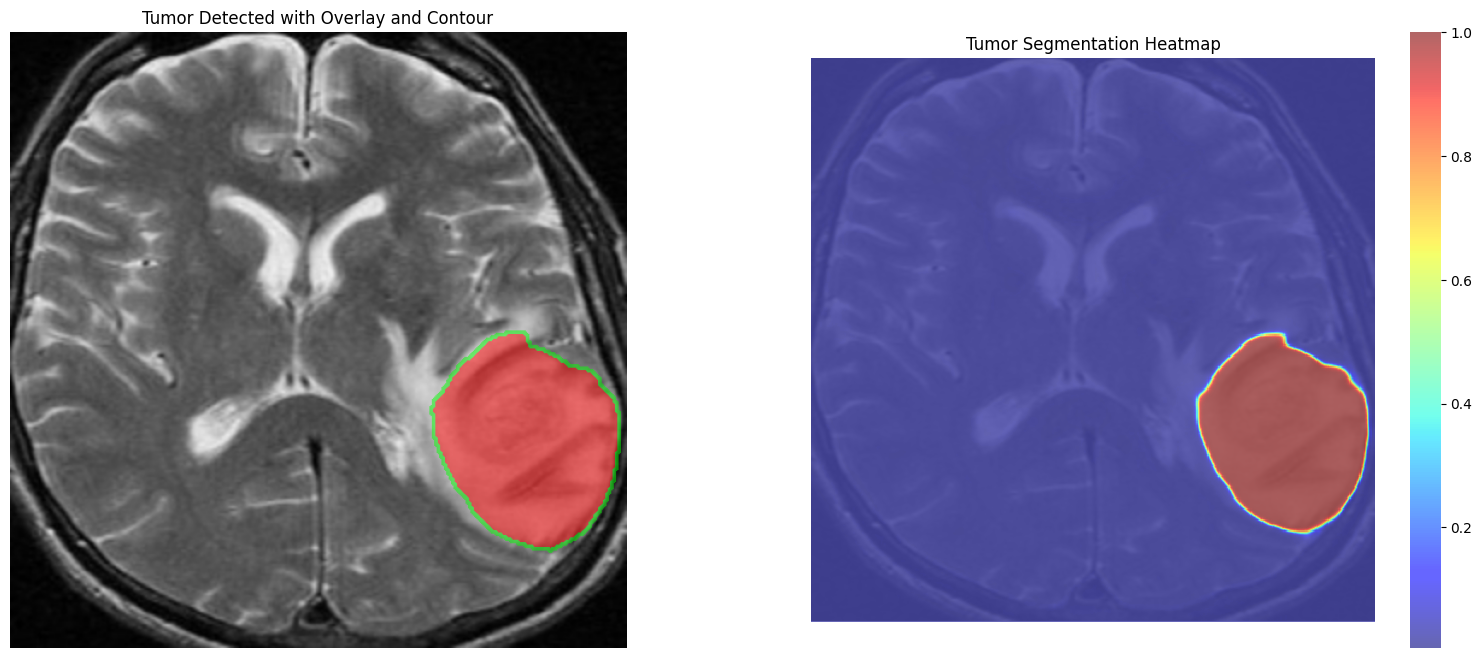

In [10]:
# Example usage
image_path = '/kaggle/input/segmentation-data/aryas/images/65.png'
predict_and_display_combined(image_path, model)